**Next steps** : Do a moisture budget analysis of the tropical region and diagnose why precip is lower downstream. Check what to add to the analytical model to match that.

In [4]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,upslope_omega_sin
from orographicPrecipitation.precip_extremes_scaling import *
from wrfProcessing import *

import warnings
from tabulate import tabulate

from wrf import cape_2d
import wrf
from netCDF4 import Dataset
from joblib import Parallel, delayed

# Data

In [5]:
def hemi_average(ds):
    return (ds.isel(south_north=range(69,-1,-1))+ds.isel(south_north=range(70,140)))/2
def sel_time(ds,wrfds):
    return ds.isel(time=range(50*wrfds.nhours,len(wrfds.vars.time)))

In [6]:
def sel_crosseqtropicmountain(ds):
    return ds.sel(west_east=slice(38,40),south_north=slice(64,75))
with warnings.catch_warnings():
    warnings.simplefilter("ignore",FutureWarning)
    
    Mcont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","new.wrf.crosseq.mountain.100km.300d"  ,"Mountain, control"  ,sel_crosseqtropicmountain,'gold',open_ds=1      ,shifttimes=0)
    Acont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","new.wrf.crosseq.aquaplanet.100km.300d","Aquaplanet, control",sel_crosseqtropicmountain,'dodgerblue',open_ds=1,shifttimes=0)
    

loading time : 15.4 s
Daily precips already computed
precips time : 0.2 s
loading time : 17.1 s
Daily precips already computed
precips time : 0.2 s


In [4]:
def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

num_cores = 16
wrf.omp_set_num_threads(32)
def compute_cape(simulation_path):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    capecin_list = Parallel(n_jobs=num_cores)(delayed(compute_individual_cape)(file) for file in files[5:])
    return xr.combine_nested(capecin_list,concat_dim='Time')

In [5]:
%time Mcontcapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/")
McontCAPEmean = Mcontcapecin.isel(mcape_mcin_lcl_lfc=0).mean('Time')

CPU times: user 380 ms, sys: 433 ms, total: 813 ms
Wall time: 31 s


In [6]:
%time Acontcapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.aquaplanet.100km.300d/")
AcontCAPEmean = Acontcapecin.isel(mcape_mcin_lcl_lfc=0).mean('Time')

CPU times: user 251 ms, sys: 247 ms, total: 498 ms
Wall time: 28.4 s


In [7]:
%time Mwarmcapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.SST2K_2XCO2.300d/")
MwarmCAPEmean = Mwarmcapecin.isel(mcape_mcin_lcl_lfc=0).mean('Time')

CPU times: user 274 ms, sys: 197 ms, total: 471 ms
Wall time: 31.1 s


In [8]:
%time Awarmcapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.aquaplanet.100km.SST2K_2XCO2.300d/")
AwarmCAPEmean = Awarmcapecin.isel(mcape_mcin_lcl_lfc=0).mean('Time')

CPU times: user 394 ms, sys: 232 ms, total: 626 ms
Wall time: 31.2 s


In [58]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

# Approximate CAPE

In [29]:
def compute_cape(ds):
    Lv = 2257e3 #latent heat of vaporization of water, 100°C, in J/kg
    cp = 1e3 #specific heat at constant pressure of air, 100°C, in J/K/kg
    midp = 500. #mid-tropospheric pressure
    blp = 950. # bl pressure
    g = 9.81

    # Compute Boundary layer MSE (h_b)
    #h_b = g*ds.Z_sfc + cp*(273.15+ds.T_2m) + Lv*ds.q_2m
    h_b = g*ds.Z_p.sel(level=blp) + cp*ds.T_p.sel(level=blp) + Lv*ds.q_p.sel(level=blp)
    
    # Compute 500hPa saturation MSE (hsat_mid)
    T_mid = ds.T_p.sel(level=midp)
    hsat_mid = g*ds.Z_p.sel(level=midp) + cp*T_mid + Lv*qsat(T_mid,midp)
    
    return (h_b-hsat_mid)*(h_b-hsat_mid > 0.)

In [30]:
%%time 
McontCAPE = compute_cape(Mcont.vars).load()
AcontCAPE = compute_cape(Acont.vars).load()

CPU times: user 18.2 s, sys: 22.9 s, total: 41.1 s
Wall time: 18.6 s


In [31]:
tropics_limit=5

def mean_rest_tropics(x):
    return x.sel(west_east=((x.west_east<20)|(x.west_east>60)),south_north=slice(70-tropics_limit,70+tropics_limit)).mean(['west_east','south_north'])


In [18]:
%%time
Lv = 2257e3 #latent heat of vaporization of water, 100°C, in J/kg
cp = 1e3 #specific heat at constant pressure of air, 100°C, in J/K/kg
g = 9.81

h_b  = g*(Mcont.vars.Z_sfc) + cp*(273.15+Mcont.vars.T_2m) + Lv*Mcont.vars.q_2m
h    = g*Mcont.vars.Z_p + cp*Mcont.vars.T_p+ Lv*ds.vars.q_p
hsat = g*Mcont.vars.Z_p + cp*Mcont.vars.T_p+ Lv*qsat(Mcont.vars.T_p,Mcont.vars.level)
h_tropics = mean_rest_tropics(h).load()
hsat_tropics = mean_rest_tropics(hsat).load()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 17.6 s, sys: 21 s, total: 38.5 s
Wall time: 11.1 s


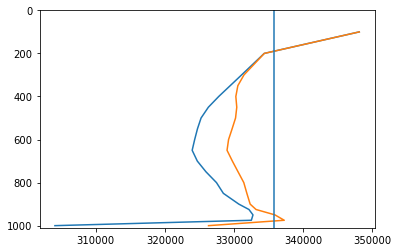

In [19]:
plt.plot(h_tropics.mean('time'),h_tropics.level)
plt.plot(hsat_tropics.mean('time'),h_tropics.level)
plt.ylim((1010,0))
plt.axvline(mean_rest_tropics(h_b).mean('time'))

# Exact CAPE

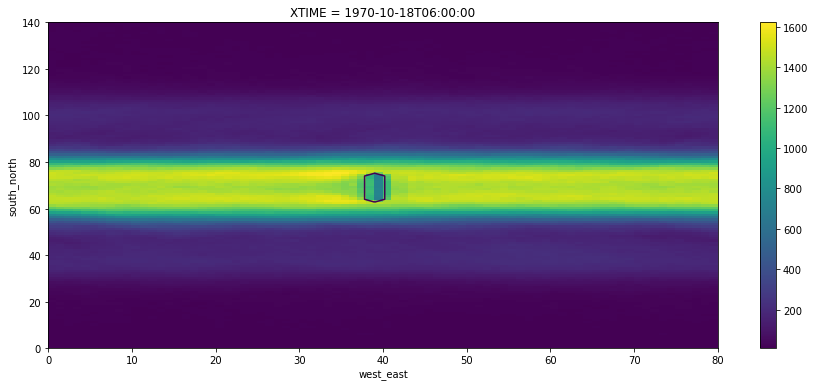

In [28]:
mtn=xr.open_dataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/wrfout_d01_1970-*"))[-1]).HGT.isel(Time=0)
def plot_2dvar(var,ax):
    c = ax.pcolormesh(np.array(var))
    plt.colorbar(c,ax=ax)
    mtn.plot.contour(ax=ax,**{'levels':[100.]})
fig, ax = plt.subplots(1,1,figsize=(15,6))
plot_2dvar(McontCAPEmean,ax)


In [61]:
mtn=xr.open_dataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/wrfout_d01_1970-*"))[-1]).HGT.isel(Time=0)
mtn=hemi_average(mtn)

def plot_2dvar(var,ax,cm=plt.cm.viridis,scale=None):
    if scale :
        c = ax.pcolormesh(np.array(var),cmap=cm,vmin=-scale,vmax=scale)
    else:
        c = ax.pcolormesh(np.array(var),cmap=cm)
    plt.colorbar(c,ax=ax)
    mtn.plot.contour(ax=ax,**{'levels':[200.]})

def plot_diff(ds1,ds2,ax,cm=plt.cm.viridis,scale=None):
    diff = hemi_average(ds1 - ds2)
    #diff, pval = ttest_1samp(diff, 0, "time")
    plot_2dvar(diff,ax,cm,scale=scale)

Text(0.5, 1.0, 'Mountain CAPE - Aquaplanet CAPE')

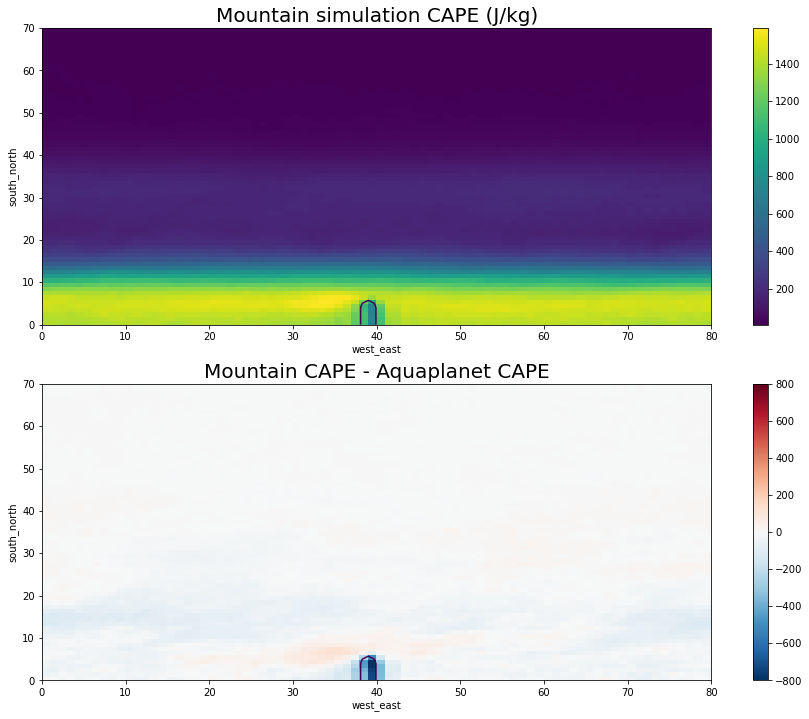

In [63]:
fig, ax = plt.subplots(2,1,figsize=(15,2*6))
ax = ax.reshape(-1)
plot_2dvar(hemi_average(McontCAPEmean),ax[0])
plot_diff(McontCAPEmean,AcontCAPEmean,ax[1],cm=plt.cm.RdBu_r,scale=800)
ax[0].set_title("Mountain simulation CAPE (J/kg)",fontsize=20)
ax[1].set_title("Mountain CAPE - Aquaplanet CAPE",fontsize=20)


# Cross section plots

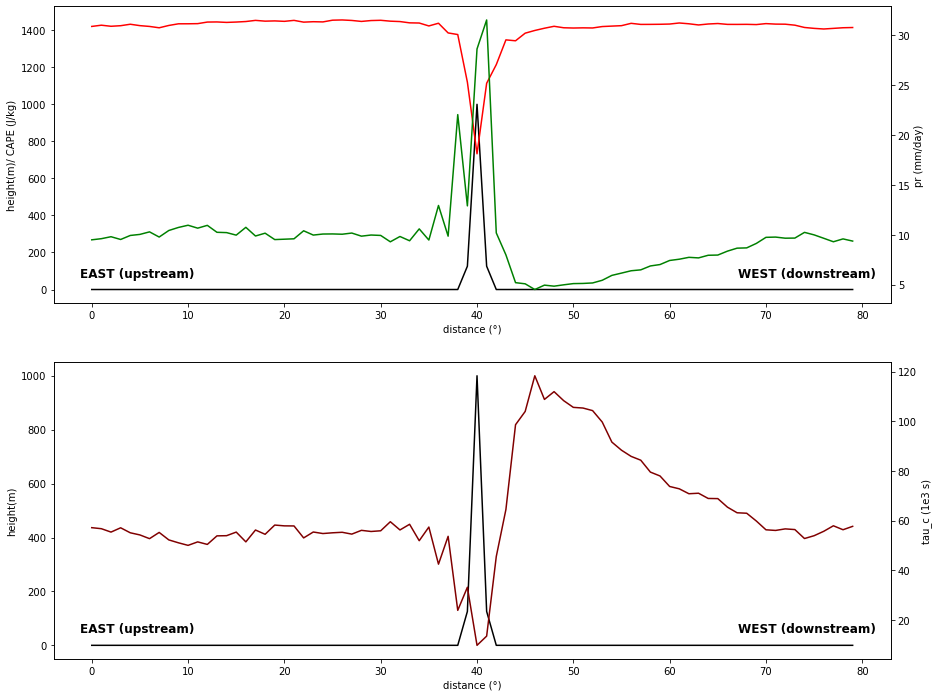

In [130]:
fig, ax = plt.subplots(2,1,figsize=(15,2*6))

ax[0].set_xlabel("distance (°)")
ax[0].set_ylabel("height(m)/ CAPE (J/kg)")
ax[0].plot(Mcont.vars.Z_sfc.west_east,Mcont.vars.Z_sfc.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1],color='k')
ax[0].plot(McontCAPEmean.west_east,McontCAPEmean.sel(south_north=slice(66,73)).mean(['south_north'])[::-1],color='r')
ax2=ax[0].twinx()
ax2.set_ylabel("pr (mm/day)")
ax2.plot(Mcont.precip_daily.west_east,Mcont.precip_daily.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1],color='green')

factor = 2.26e6/(86400*1e4) #convert pr to J/kg / s : convert to mm/s, multiply by Lv, divide by atmospheric mass
ax[1].set_xlabel("distance (°)")
ax[1].set_ylabel("height(m)")
ax[1].plot(Mcont.vars.Z_sfc.west_east,Mcont.vars.Z_sfc.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1],color='k')
ax2=ax[1].twinx()
ax2.set_ylabel("tau_c (1e3 s)")
ax2.plot(Mcont.precip_daily.west_east,1/(1000*factor)*McontCAPEmean.sel(south_north=slice(66,73)).mean(['south_north'])[::-1]/Mcont.precip_daily.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1],color='maroon')

add_text(ax[0]);add_text(ax[1])

# CAPE change with warming

Text(0.5, 1.0, 'CAPE change w/ warming (%/K)')

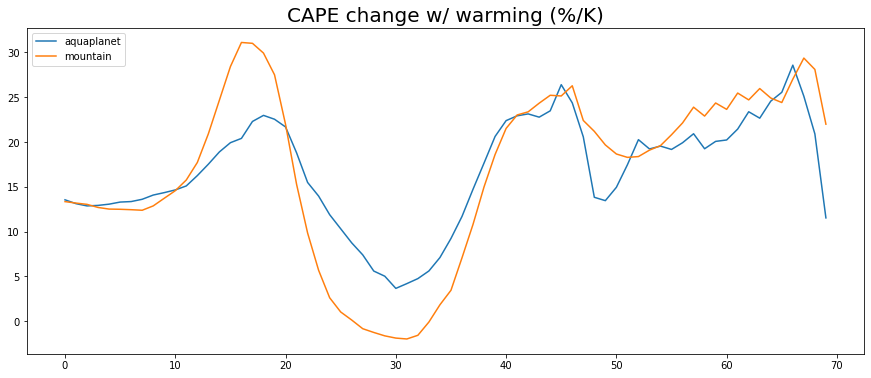

In [83]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
Mcapechange = 100*(hemi_average(MwarmCAPEmean)/hemi_average(McontCAPEmean) -1)/2
Acapechange = 100*(hemi_average(AwarmCAPEmean)/hemi_average(AcontCAPEmean) -1)/2

ax.plot(Acapechange.south_north,Acapechange.mean('west_east'),label='aquaplanet')
ax.plot(Mcapechange.south_north,Mcapechange.mean('west_east'),label='mountain')


ax.legend()
ax.set_title("CAPE change w/ warming (%/K)",fontsize=20)


# Further checks 

In [7]:
Mcontpath = "/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/"
Mcontwrf = xr.open_mfdataset(sorted(glob.glob(Mcontpath+'wrfout_d01_197*'))[5:],combine='nested',concat_dim='Time',parallel=True)

In [8]:
Acontpath = "/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.aquaplanet.100km.300d/"
Acontwrf = xr.open_mfdataset(sorted(glob.glob(Acontpath+'wrfout_d01_197*'))[5:],combine='nested',concat_dim='Time',parallel=True)

In [12]:
for i,v in enumerate(Mcontwrf.variables):
    if i>0:
        print(v,Mcontwrf[v].description)

XLAT LATITUDE, SOUTH IS NEGATIVE
XLONG LONGITUDE, WEST IS NEGATIVE
LU_INDEX LAND USE CATEGORY
ZNU eta values on half (mass) levels
ZNW eta values on full (w) levels
U x-wind component
V y-wind component
W z-wind component
PH perturbation geopotential
PHB base-state geopotential
T perturbation potential temperature theta-t0
THM either 1) pert moist pot temp=(1+Rv/Rd Qv)*(theta)-T0, or 2) pert dry pot temp=t
MU perturbation dry air mass in column
MUB base state dry air mass in column
P perturbation pressure
PB BASE STATE PRESSURE
RHO DENSITY
THIS_IS_AN_IDEAL_RUN T/F flag: this is an ARW ideal simulation
P_HYD hydrostatic pressure
Q2 QV at 2 M
T2 TEMP at 2 M
TH2 POT TEMP at 2 M
PSFC SFC PRESSURE
U10 U at 10 M
V10 V at 10 M
RDX INVERSE X GRID LENGTH
RDY INVERSE Y GRID LENGTH
ZETATOP ZETA AT MODEL TOP
ITIMESTEP 
XTIME minutes since 1970-01-01 00:00:00
QVAPOR Water vapor mixing ratio
QCLOUD Cloud water mixing ratio
QRAIN Rain water mixing ratio
QICE Ice mixing ratio
QSNOW Snow mixing ratio
Q

In [59]:
mtn=xr.open_dataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.300d/wrfout_d01_1970-*"))[-1]).HGT.isel(Time=0)
def plot_2dvar(var,ax):
    c = ax.pcolormesh(np.array(var))
    plt.colorbar(c,ax=ax)
    mtn.plot.contour(ax=ax,**{'levels':[100.]})

## Surface fluxes

In [46]:
%time evap = Mcontwrf.QFX.mean('Time').persist()

CPU times: user 252 ms, sys: 3.3 s, total: 3.56 s
Wall time: 32.9 s


Note 5mm/day corresponds to 130 W/m^2


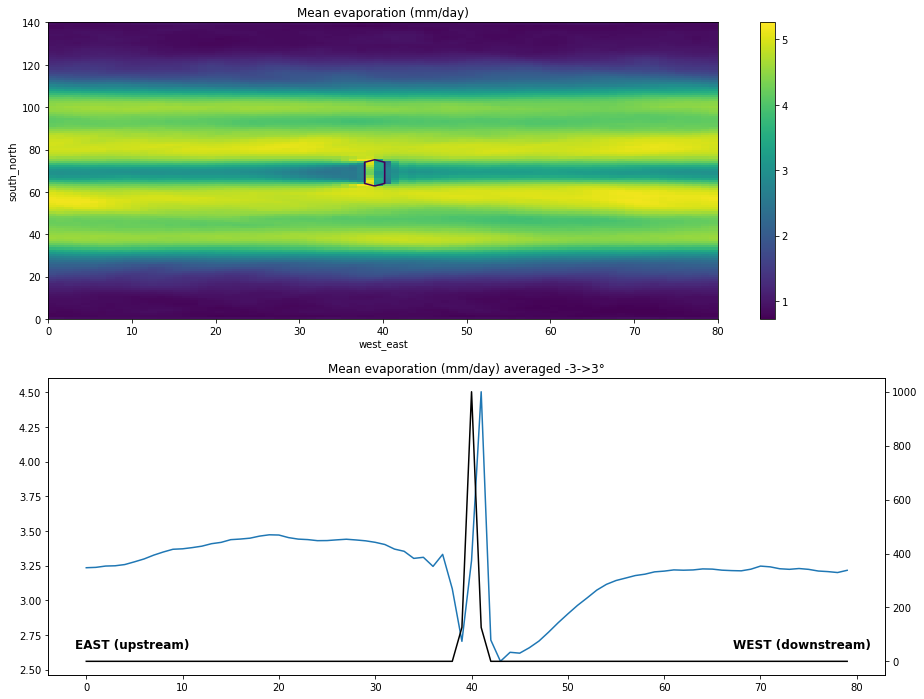

In [62]:
trop_width=3
fig, ax = plt.subplots(2,1,figsize=(15,12))

plot_2dvar(evap*86400,ax[0])
ax[1].plot(evap.west_east,86400*evap.isel(south_north=slice(70-trop_width-1,70+trop_width)).mean('south_north')[::-1])
ax[1].twinx().plot(Mcont.vars.Z_sfc.west_east,(Mcont.vars.Z_sfc.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1]),color='k')
ax[0].set_title("Mean evaporation (mm/day)")
ax[1].set_title("Mean evaporation (mm/day) averaged -3->3°")
print("Note 5mm/day corresponds to %i W/m^2"%(2.26e6*5/86400))

add_text(ax[1])

## Radiative cooling

In [64]:
%%time 
mSWUPT = (Mcontwrf.ACSWUPT.isel(Time = -1)-Mcontwrf.ACSWUPT.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600
mSWDNT = (Mcontwrf.ACSWDNT.isel(Time = -1)-Mcontwrf.ACSWDNT.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600
mSWUPB = (Mcontwrf.ACSWUPB.isel(Time = -1)-Mcontwrf.ACSWUPB.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600
mSWDNB = (Mcontwrf.ACSWDNB.isel(Time = -1)-Mcontwrf.ACSWDNB.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600
mLWUPT = (Mcontwrf.ACLWUPT.isel(Time = -1)-Mcontwrf.ACLWUPT.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600
mLWDNT = (Mcontwrf.ACLWDNT.isel(Time = -1)-Mcontwrf.ACLWDNT.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600
mLWUPB = (Mcontwrf.ACLWUPB.isel(Time = -1)-Mcontwrf.ACLWUPB.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600
mLWDNB = (Mcontwrf.ACLWDNB.isel(Time = -1)-Mcontwrf.ACLWDNB.isel(Time = 0)).persist()/(len(Mcontwrf.Time)-1)/6/3600

CPU times: user 526 ms, sys: 29.6 ms, total: 556 ms
Wall time: 713 ms


In [65]:
rad_cooling = mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB


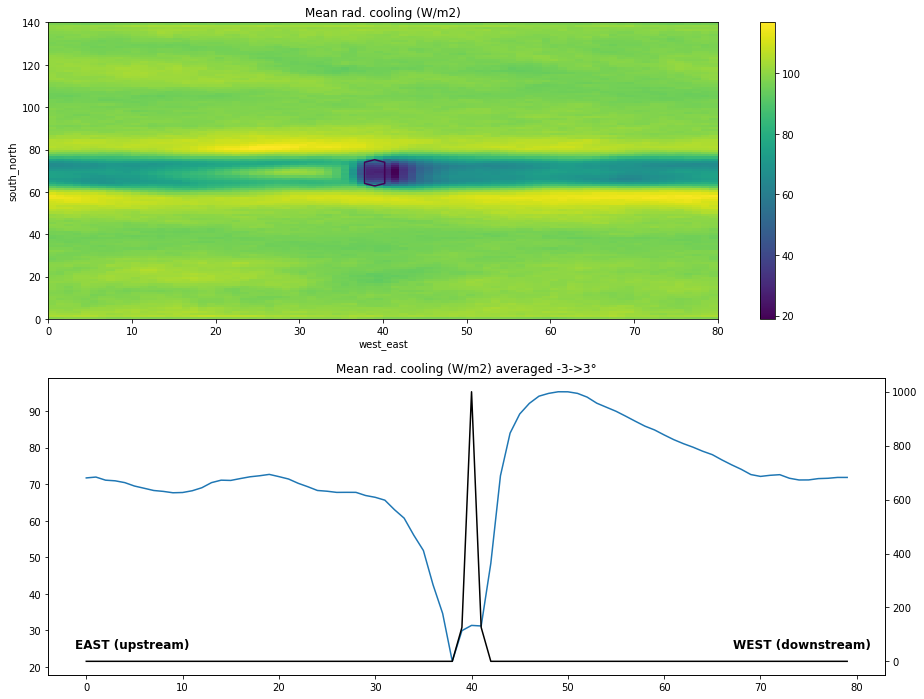

In [66]:
trop_width=3
fig, ax = plt.subplots(2,1,figsize=(15,12))

plot_2dvar(rad_cooling,ax[0])
ax[1].plot(rad_cooling.west_east,rad_cooling.isel(south_north=slice(70-trop_width-1,70+trop_width)).mean('south_north')[::-1])
ax[1].twinx().plot(Mcont.vars.Z_sfc.west_east,(Mcont.vars.Z_sfc.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1]),color='k')
ax[0].set_title("Mean rad. cooling (W/m2)")
ax[1].set_title("Mean rad. cooling (W/m2) averaged -3->3°")
add_text(ax[1])

## Mean 850hpa zonal wind in the tropics

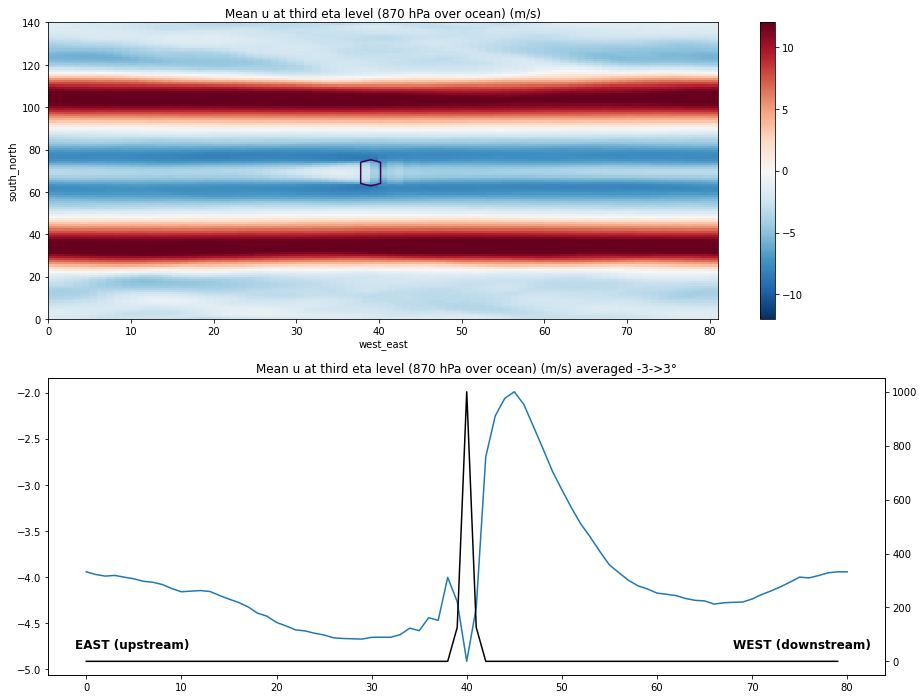

In [67]:
def plot_2dvar_sym(var,ax):
    c = ax.pcolormesh(np.array(var),cmap=plt.cm.RdBu_r,vmin=-12,vmax=12)
    plt.colorbar(c,ax=ax)
    mtn.plot.contour(ax=ax,**{'levels':[100.]})
u_lev2 = Mcontwrf.U.sel(bottom_top=2).mean('Time').persist()
trop_width=3
fig, ax = plt.subplots(2,1,figsize=(15,12))

plot_2dvar_sym(u_lev2,ax[0])
ax[1].plot(u_lev2.west_east_stag,u_lev2.isel(south_north=slice(70-trop_width-1,70+trop_width)).mean('south_north')[::-1])
ax[1].twinx().plot(Mcont.vars.Z_sfc.west_east,(Mcont.vars.Z_sfc.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1]),color='k')
ax[0].set_title("Mean u at third eta level (870 hPa over ocean) (m/s)")
ax[1].set_title("Mean u at third eta level (870 hPa over ocean) (m/s) averaged -3->3°")

add_text(ax[1])

Text(0.5, 1.0, 'Mean M minus A  u at third eta level (870 hPa over ocean) (m/s)')

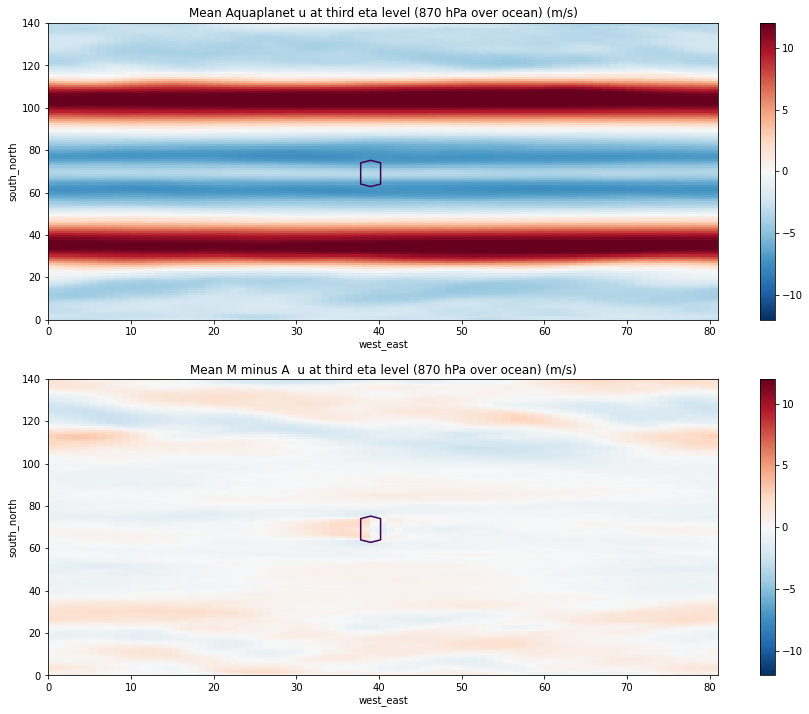

In [34]:
A_u_lev2 = Acontwrf.U.sel(bottom_top=2).mean('Time').persist()
trop_width=3
fig, ax = plt.subplots(2,1,figsize=(15,12))

plot_2dvar_sym(A_u_lev2,ax[0])
plot_2dvar_sym(u_lev2-A_u_lev2,ax[1])
ax[0].set_title("Mean Aquaplanet u at third eta level (870 hPa over ocean) (m/s)")
ax[1].set_title("Mean M minus A  u at third eta level (870 hPa over ocean) (m/s)")


# Moisture budget analysis

In [10]:
from tools.e5tools import ddx,ddy,divergence

In [11]:
Mcontpdata = Mcont.vars.rename({'lat':'latitude','lon':'longitude'})
Mcontpdata['latitude'] = Mcontpdata.latitude.isel(west_east=0)
Mcontpdata['longitude'] = Mcontpdata.longitude.isel(south_north=0)+np.arange(1.,81.,1.)
Mcontpdata = Mcontpdata.swap_dims({"south_north":"latitude","west_east":"longitude"})
Mcontpdata = Mcontpdata.reindex(latitude=list(reversed(Mcontpdata.latitude))).transpose("time","level","latitude","longitude")

In [30]:
def ddx(F):
    """return zonal derivative on the beta plane"""
    m_per_degreelat = 100000.
    return F.differentiate("longitude")/m_per_degreelat

def ddy(F):
    """return meridional derivative in spherical coordinates"""
    m_per_degreelat = 100000.
    return F.differentiate("latitude")/m_per_degreelat

def divergence(Fx,Fy):
    """return divergence in spherical coordinates"""
    return ddx(Fx)+ddy(Fy)

def p_k_half(ps,plevs):
    """Given a surface pressure in Pa,
    return the pressure level p_{k+1/2} from which to compute the surface part 
    of the integral (see SeagerHenderson2013 - eq (22))
    args :
     - ps (float) : surface pressure in Pa
     - plevs (float list) : array pressure levels in Pa, increasing order
     
     Namely, finds the pressure levels p_k and p_{k+1} such that pk <= ps < p_{k+1}
     and returns (p_k + p_{k+1})/2; if ps >= 1e5 Pa = 1000 hPa, returns 1e5 Pa
    """    
    return (plevs[np.searchsorted(plevs,ps)-1]+
            plevs[np.minimum(np.searchsorted(plevs,ps),len(plevs)-1)])/2

def compute_mc_terms(q,u,v,w,ps):
    uq = u*q  
    uq_vinteg = ((uq*(100*uq.level<ps)).integrate("level")*100 +
                 (uq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half,ps,100*u.level,input_core_dims=[[],['level']],dask="parallelized"))  
                 )#sfc_term = uq_k * (p_s - p_{k+1/2})
                )
    
    vq = v*q  
    vq_vinteg = ((vq*(100*vq.level<ps)).integrate("level")*100 +
                 (vq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half,ps,100*u.level,input_core_dims=[[],['level']],dask="parallelized"))  
                 )#sfc_term = vq_k * (p_s - p_{k+1/2})
                )

    mc   = - divergence(uq_vinteg,vq_vinteg)/(9.81*1000)*1000*86400
    
    #minimum surface pressure of the neighboring elements of each grid cell
    psa = np.array(ps )
    psa_n = np.amin(np.array([psa,np.roll(psa,(1,0)),np.roll(psa,(-1,0)),np.roll(psa,(0,1)),np.roll(psa,(0,-1))]),axis=0) 
    ps_n = xr.DataArray(psa_n,ps.coords)
    
    #Mean wind convergence = -<q*div(u)>
    ddp_w = w.differentiate("level",edge_order=2)/100.
    conv_term = (q*ddp_w*(100*ddp_w.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    #conv_term 2 = -(q  *divergence(u  ,v  )*(100*q.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #Minus moisture advection = -<u.grad(q)>
    adv_term  = -((u*ddx(q)+v*ddy(q))*(100*u.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #surface contribution
    sfc_term = mc -conv_term-adv_term
    return mc ,conv_term,adv_term,sfc_term

def compute_mc_terms_wrfds(wrfdsvars,wrfds):
    ww = sel_time(wrfdsvars.w_p,wrfds).ffill('level')
    t = sel_time(wrfdsvars.T_p,wrfds).ffill('level')
    rho = t.level*100/(287.*t)
    return compute_mc_terms(sel_time(wrfdsvars.q_p,wrfds).ffill('level'),
                            sel_time(wrfdsvars.u_gr_p,wrfds).ffill('level'),
                            sel_time(wrfdsvars.v_gr_p,wrfds).ffill('level'),
                            -9.81*rho*ww,
                            100*sel_time(wrfdsvars.p_sfc,wrfds))

In [31]:
%%time
%time mc ,conv_term,adv_term,sfc_term = compute_mc_terms_wrfds(Mcontpdata,Mcont)
print('done 1')
mc.persist()       
conv_term.persist()
adv_term.persist() 
sfc_term.persist() 
None

CPU times: user 4min 26s, sys: 7.91 s, total: 4min 33s
Wall time: 4min 36s
done 1
CPU times: user 7min 32s, sys: 1min 37s, total: 9min 9s
Wall time: 6min 50s


In [32]:
%%time
mc_tm        = mc.mean('time').persist()       
conv_term_tm = conv_term.mean('time').persist()  
adv_term_tm  = adv_term.mean('time').persist()  
sfc_term_tm  = sfc_term.mean('time').persist()   

CPU times: user 3min 13s, sys: 1min 31s, total: 4min 44s
Wall time: 2min 15s


In [40]:
%%time 
def sfc_term2(q,u,v,ps):
    q_surf = q.sel(level = ps/100, method = 'ffill')
    u_surf = u.sel(level = ps/100, method = 'ffill')
    v_surf = v.sel(level = ps/100, method = 'ffill')
    sfc_term2 = -q_surf*(u_surf*ddx(ps)+v_surf*ddy(ps))/(9.81*1000)*1000*86400
    return sfc_term2
%time sfc2 =  sfc_term2(sel_time(Mcontpdata.q_p,Mcont).ffill('level'),sel_time(Mcontpdata.u_gr_p,Mcont).ffill('level'),sel_time(Mcontpdata.v_gr_p,Mcont).ffill('level'),100*sel_time(Mcontpdata.p_sfc,Mcont))
sfc2=sfc2.persist()

CPU times: user 9min 22s, sys: 32.7 s, total: 9min 55s
Wall time: 9min 59s
CPU times: user 11min 26s, sys: 54.3 s, total: 12min 20s
Wall time: 12min


In [41]:
%time sfc2_tm = sfc2.mean('time').persist()   

CPU times: user 104 ms, sys: 63.7 ms, total: 167 ms
Wall time: 23.3 ms


Text(0.5, 1.0, 'residual')

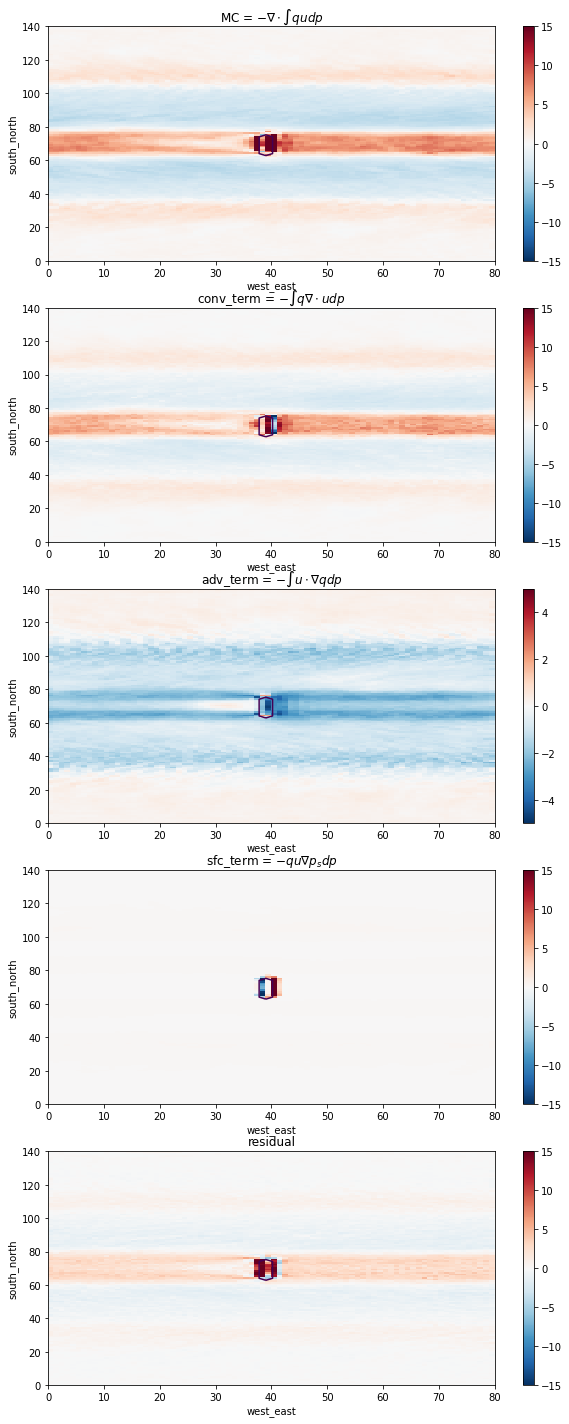

In [45]:
def plot_2dvar_sym(var,ax,scale):
    c = ax.pcolormesh(np.array(var),cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    plt.colorbar(c,ax=ax)
    mtn.plot.contour(ax=ax,**{'levels':[100.]})

fig, ax = plt.subplots(5,1,figsize=(10,25))
plot_2dvar_sym(mc_tm        ,ax[0],15);ax[0].set_title(r"MC = $-\nabla \cdot \int qu dp$")
plot_2dvar_sym(conv_term_tm ,ax[1],15 );ax[1].set_title(r"conv_term = $-\int q \nabla\cdot u dp$")
plot_2dvar_sym(adv_term_tm  ,ax[2],5 );ax[2].set_title(r"adv_term = $-\int u \cdot \nabla q dp$")
plot_2dvar_sym(sfc2_tm      ,ax[3],15);ax[3].set_title(r"sfc_term = $-qu \nabla p_s dp$")
plot_2dvar_sym(sfc_term_tm-sfc2_tm  ,ax[4],15);ax[4].set_title("residual")

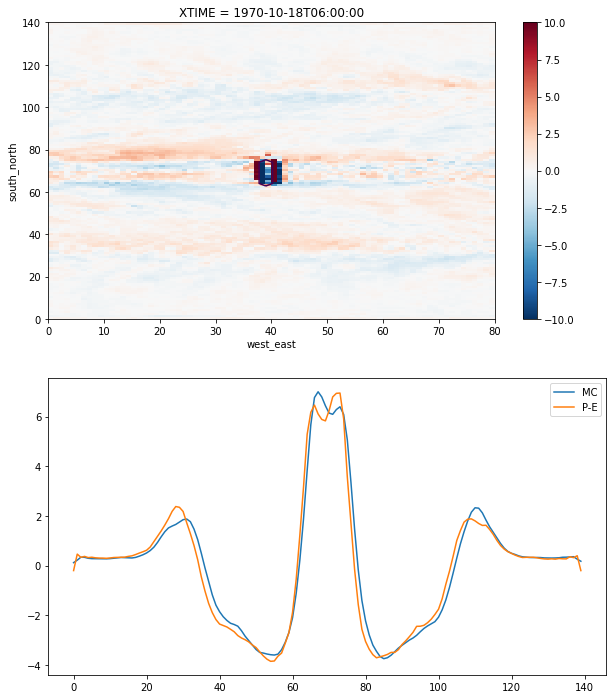

In [49]:
fig, ax = plt.subplots(2,1,figsize=(10,12))
plot_2dvar_sym(np.array(mc_tm)-np.array(Mcont.precip_daily.mean('time') - 86400*evap),ax[0],10)
ax[1].plot(mc_tm.mean(['longitude']),label='MC')
ax[1].plot((Mcont.precip_daily.mean('time') - 86400*evap).mean('west_east'),label='P-E')
ax[1].legend()

# Moisture advection $u\cdot \nabla q$ and large-scale vertical motion cross-sections

In [55]:
trop_width=3
%time w_crosssection = Mcontpdata.w_p.sel(level=750.).isel(latitude=slice(70-trop_width-1,70+trop_width)).mean(['time','latitude']).persist()

CPU times: user 2.7 s, sys: 7.27 s, total: 9.97 s
Wall time: 13.6 s


In [56]:
adv_term_tm_crosssection = adv_term_tm.isel(latitude=slice(70-trop_width-1,70+trop_width)).mean(['latitude'])

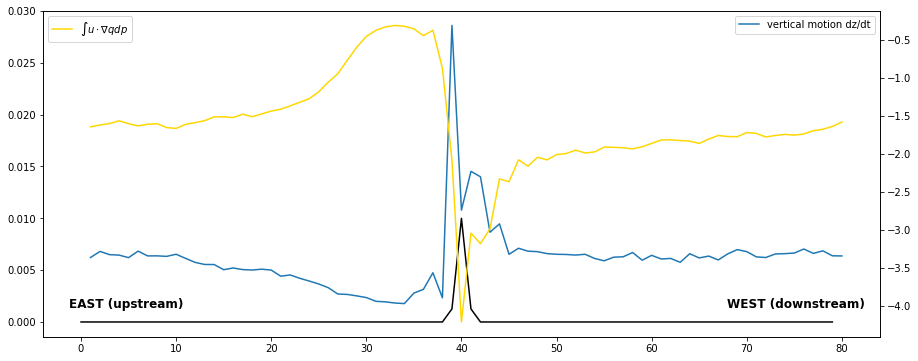

In [77]:
fig, ax = plt.subplots(1,1,figsize=(15,6))

ax.plot(w_crosssection.longitude,w_crosssection,label='vertical motion dz/dt')
ax2=ax.twinx()
ax2.plot(adv_term_tm_crosssection.longitude,adv_term_tm_crosssection,label=r'$\int u \cdot \nabla q dp$',color='gold')
ax.plot(Mcont.vars.Z_sfc.west_east,(Mcont.vars.Z_sfc.sel(south_north=slice(66,73)).mean(['south_north','time'])[::-1])/1e5,color='k')
#ax[0].set_title("Mean evaporation (mm/day)")
#ax[1].set_title("Mean evaporation (mm/day) averaged -3->3°")
#print("Note 5mm/day corresponds to %i W/m^2"%(2.26e6*5/86400))


ax.legend();ax2.legend(loc='upper left')

# GMS / Moisture stratification

In [ ]:
ww = sel_time(wrfdsvars.w_p,wrfds).ffill('level')
t = sel_time(wrfdsvars.T_p,wrfds).ffill('level')

In [78]:
Mcontwrf

<xarray.Dataset>
Dimensions:               (Time: 1001, bottom_top: 38, bottom_top_stag: 39, snow_layers_stag: 3, snso_layers_stag: 7, south_north: 140, south_north_stag: 141, west_east: 80, west_east_stag: 81)
Coordinates:
    XLAT                  (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    XLONG                 (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    XTIME                 (Time) datetime64[ns] dask.array<chunksize=(40,), meta=np.ndarray>
    XLAT_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(40, 140, 81), meta=np.ndarray>
    XLONG_U               (Time, south_north, west_east_stag) float32 dask.array<chunksize=(40, 140, 81), meta=np.ndarray>
    XLAT_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(40, 141, 80), meta=np.ndarray>
    XLONG_V               (Time, south_north_stag, west_east) float32 dask.array<chunksize=(40, 141, 80), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, snow_layers_stag, snso_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                 (Time) |S19 dask.array<chunksize=(40,), meta=np.ndarray>
    LU_INDEX              (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    ZNU                   (Time, bottom_top) float32 dask.array<chunksize=(40, 38), meta=np.ndarray>
    ZNW                   (Time, bottom_top_stag) float32 dask.array<chunksize=(40, 39), meta=np.ndarray>
    U                     (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(40, 38, 140, 81), meta=np.ndarray>
    V                     (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(40, 38, 141, 80), meta=np.ndarray>
    W                     (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(40, 39, 140, 80), meta=np.ndarray>
    PH                    (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(40, 39, 140, 80), meta=np.ndarray>
    PHB                   (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(40, 39, 140, 80), meta=np.ndarray>
    T                     (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    THM                   (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    MU                    (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    MUB                   (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    P                     (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    PB                    (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    RHO                   (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    THIS_IS_AN_IDEAL_RUN  (Time) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    P_HYD                 (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    Q2                    (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    T2                    (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    TH2                   (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    PSFC                  (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    U10                   (Time, south_north, west_east) float32 dask.array<chun